In [6]:
!pip install -q langchain langchain_core langchain-google-genai langchain_community langgraph

In [1]:
import os
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableSequence

from IPython.display import display, Image, Markdown

### Load Model

In [2]:
from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [9]:
def load_gemini_model():
    try:
        model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                            temperature=0.1,
                            # convert_system_message_to_human=True,
                            max_tokens=512,
                            timeout=None,
                            max_retries=2,
                            top_k=90,
                            top_p=0.5
                        )
        print('Gemini Model successfully loaded')
        return model
    except Exception as e:
        print(f'Error loading Gemini Model: {str(e)}')
        raise

model = load_gemini_model()
Markdown(model.invoke('what is the use case of agents').content)

Gemini Model successfully loaded


The use cases for agents are incredibly broad and depend heavily on the type of agent being discussed (e.g., software agent, human agent, AI agent).  However, some common themes emerge:

**General Use Cases (applicable across agent types):**

* **Automation:** Agents automate tasks, freeing up human time and resources. This could range from simple tasks like scheduling appointments to complex ones like managing supply chains.
* **Delegation:** Agents act on behalf of a principal (person or system), carrying out instructions and making decisions within defined parameters.
* **Coordination:** Agents can coordinate the actions of multiple entities, improving efficiency and collaboration.  This is crucial in complex systems like traffic management or distributed computing.
* **Information Gathering and Filtering:** Agents can collect and process information from various sources, filtering out irrelevant data and presenting only the essential information to the user.
* **Decision Making:**  Agents can make decisions based on pre-programmed rules, learned behavior, or a combination of both.  This can range from simple if-then rules to complex machine learning models.
* **Problem Solving:** Agents can be designed to solve specific problems, such as optimizing resource allocation, finding the shortest route, or diagnosing faults.


**Specific Use Cases by Agent Type:**

* **Software Agents (e.g., bots, virtual assistants):**
    * **Customer service:** Answering questions, resolving issues, and providing support.
    * **E-commerce:** Recommending products, processing orders, and managing customer accounts.
    * **Search engines:** Crawling the web, indexing content, and retrieving relevant results.
    * **Network management:** Monitoring network performance, detecting anomalies, and resolving issues.
    * **Data analysis:** Collecting, cleaning, and analyzing data to identify trends and insights.
    * **Game playing:** Playing games against humans or other agents.

* **AI Agents (e.g., reinforcement learning agents, multi-agent systems):**
    * **Robotics:** Controlling robots in various environments, such as factories, warehouses, and homes.
    * **Autonomous vehicles:** Navigating roads and making driving decisions.
    * **Personalized medicine:** Developing treatment plans based on individual patient data.
    * **Financial modeling:** Predicting market trends and making investment decisions.
    * **Scientific discovery:** Analyzing data and formulating hypotheses.

* **Human Agents (e.g., customer service representatives, real estate agents):**
    * **Sales and

### Defining Message State

In [10]:
class StateSupport(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

### Define Nodes/Tools

In [31]:
def categorize_query_tool(state: StateSupport) -> StateSupport:
    "Technical, Billing, General"
    category_prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )

    category_chain = RunnableSequence(category_prompt | model)
    category = category_chain.invoke({'query' : state['query']}).content

    return {
          **state,
          "category": category,
      }


def analyze_sentiment_tool(state: StateSupport) -> StateSupport:
    sentiment_promt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query"
        "Response with either 'Position', 'Neutral' , or 'Negative'. Query: {query}"
    )

    sentiment_chain = RunnableSequence(sentiment_promt | model)
    sentiment = sentiment_chain.invoke({'query' : state['query']}).content
    return {
        **state,
        "sentiment": sentiment
    }


def technical_tool(state: StateSupport) -> StateSupport:
    technical_prpmpt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query : {query}"
    )

    technical_chain = RunnableSequence(technical_prpmpt | model)
    technical_response = technical_chain.invoke({"query" : state['query']}).content
    return {
        **state,
        "response" : technical_response
    }


def billing_tool(state: StateSupport) -> StateSupport:
    billing_prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query : {query}"
    )
    billing_chain = RunnableSequence(billing_prompt | model)
    billing_response = billing_chain.invoke({"query" : state['query']}).content
    return {
        **state,
        "response": billing_response
    }


def general_tool(state: StateSupport) -> StateSupport:
    general_prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query : {query}"
    )
    general_chain = RunnableSequence(general_prompt | model)
    general_response = general_chain.invoke({"query" : state['query']}).content
    return{
        **state,
        "response" : general_response
    }


def escalate(state: StateSupport) -> StateSupport:
    return {"response": "This query has been escalate to a human agent due to its negative sentiment"}


def router_query_tool(state : StateSupport) -> StateSupport:
    if state['sentiment'].lower() == "negative":
        return "Escalate_Node"
    if state['category'].lower() == "general":
        return "General_Node"
    if state['category'].lower() == "billing":
        return "Billing_Node"
    if state['category'].lower() == "technical":
        return "Technical_Node"

In [45]:
# testing Node workflow

test_state = {
        "query": "I can't log into my account.",
        "category": "",
        "sentiment": "",
        "response": "",
    }

updated_state = categorize_query_tool(test_state)
print(updated_state)


updated_state = analyze_sentiment_tool(updated_state)
print(updated_state)

updated_state = technical_tool(updated_state)
print(updated_state)

{'query': "I can't log into my account.", 'category': 'Technical', 'sentiment': '', 'response': ''}
{'query': "I can't log into my account.", 'category': 'Technical', 'sentiment': 'Negative', 'response': ''}
{'query': "I can't log into my account.", 'category': 'Technical', 'sentiment': 'Negative', 'response': "I understand you're having trouble logging into your account.  To help me assist you, please provide me with some more information:\n\n* **What is the exact error message you are receiving, if any?** (Please copy and paste the message verbatim.)\n* **What type of account is this?** (e.g., email, online banking, gaming account, social media, etc.)  This helps me understand the specific system involved.\n* **What method are you using to log in?** (e.g., website, mobile app, desktop app)\n* **Have you tried resetting your password?** If so, did you receive a password reset email/link?  If not, please check your spam/junk folder.\n* **What browser and operating system are you using?

### Define Graph

In [69]:
graph = StateGraph(StateSupport)

# create nodes
graph.add_node('Categorize_Node', categorize_query_tool)
graph.add_node('Sentiment_Node', analyze_sentiment_tool)
graph.add_node('Technical_Node', technical_tool)
graph.add_node('Billing_Node', billing_tool)
graph.add_node('General_Node', general_tool)
graph.add_node('Escalate_Node', escalate)

# create entry node
graph.set_entry_point('Categorize_Node')

# create edges
graph.add_edge('Categorize_Node', 'Sentiment_Node')

graph.add_conditional_edges(
    'Sentiment_Node',
    router_query_tool,
     {
        'Technical_Node' : 'Technical_Node',
        'Billing_Node' : 'Billing_Node',
        'General_Node' : 'General_Node',
        'Escalate_Node' : 'Escalate_Node'
    }
)

graph.add_edge('Technical_Node', END)
graph.add_edge('Billing_Node', END)
graph.add_edge('General_Node', END)
graph.add_edge('Escalate_Node', END)


app = graph.compile()


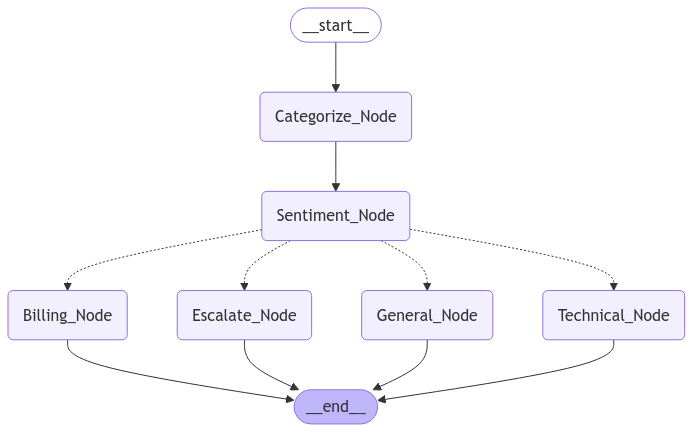

In [70]:
display(Image(app.get_graph().draw_mermaid_png()))

In [71]:
# for app.invoke({'query' : 'what is whether in india'})
state = {
      "query": "what is whether in india",
      "category": "",
      "sentiment": "",
      "response": "",
  }
for output in app.stream(state):
  print(output)

{'Categorize_Node': {'query': 'what is whether in india', 'category': 'General', 'sentiment': '', 'response': ''}}
{'Sentiment_Node': {'query': 'what is whether in india', 'category': 'General', 'sentiment': 'Neutral.  The query is a factual question, not expressing positive or negative sentiment.', 'response': ''}}
{'General_Node': {'query': 'what is whether in india', 'category': 'General', 'sentiment': 'Neutral.  The query is a factual question, not expressing positive or negative sentiment.', 'response': 'The word "whether" in India, as in the rest of the English-speaking world, is a conjunction used to introduce a choice between alternatives.  It\'s used in questions and clauses to present options.  There\'s nothing specific to India regarding its meaning or usage.  It functions identically in Indian English as it does in other varieties of English.'}}


### Run App

In [72]:
def run_agent(query : str) -> Dict[str, str]:
    response = app.invoke({'query' : query})
    return {
        "query"     : response['query'],
        "category"  : response['category'],
        "sentiment" : response['sentiment'],
        "response"  : response['response']
    }

In [73]:

query = "My internet connection is gone it's not working, Can you help me?"
result = run_agent(query)
print(f"Query: {result['query']}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


Query: My internet connection is gone it's not working, Can you help me?
Category: Technical
Sentiment: Negative
Response: This query has been escalate to a human agent due to its negative sentiment




In [81]:
query = "where can i find my receipt"
result = run_agent(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response:")
Markdown(result['response'])

Query: where can i find my receipt
Category: Billing
Sentiment: Neutral.  The query is simply a request for information; it doesn't express positive or negative sentiment.
Response:


Several options are available to locate your receipt, depending on how you made your purchase:

* **Online Account:** If you created an account with us, you can usually find your receipts in your online account history.  Log in at [link to your website's account login page] and navigate to your order history or billing section.

* **Email Confirmation:** Check your email inbox for a confirmation email from us.  This email often includes a copy of your receipt. Search your inbox for emails from [your company email address].

* **Previous Statements:** If you're looking for a receipt from a previous billing cycle, you may find it in a past statement.  [Explain how to access past statements, e.g., "You can download past statements from your online account," or "We can send you a copy of your statement if you provide your account number."].

* **Contact Us:** If you're still unable to locate your receipt, please contact us directly at [phone number] or [email address] with your account number or order number, and we'll be happy to assist you.


We appreciate your patience.

In [ ]:
# https://github.com/Chando0185/Multiverse_of_100-_data_science_project_series/blob/main/Customer%20Support%20Agent/Customer_Support_Agent_GENAI.ipynb

# Gradio App

In [9]:
!pip install -q gradio streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.7 MB/s eta 0:00:00


In [9]:
import os
import gradio as gr
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableSequence

from IPython.display import display, Image, Markdown


def load_gemini_model():
    try:
        model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                            temperature=0.1,
                            # convert_system_message_to_human=True,
                            max_tokens=512,
                            timeout=None,
                            max_retries=2,
                            top_k=90,
                            top_p=0.5
                        )
        print('Gemini Model successfully loaded')
        return model
    except Exception as e:
        print(f'Error loading Gemini Model: {str(e)}')
        raise

model = load_gemini_model()


class StateSupport(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str


def categorize_query_tool(state: StateSupport) -> StateSupport:
    "Technical, Billing, General"
    category_prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )

    category_chain = RunnableSequence(category_prompt | model)
    category = category_chain.invoke({'query' : state['query']}).content

    return {
          **state,
          "category": category,
      }


def analyze_sentiment_tool(state: StateSupport) -> StateSupport:
    sentiment_promt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query"
        "Response with either 'Position', 'Neutral' , or 'Negative'. Query: {query}"
    )

    sentiment_chain = RunnableSequence(sentiment_promt | model)
    sentiment = sentiment_chain.invoke({'query' : state['query']}).content
    return {
        **state,
        "sentiment": sentiment
    }


def technical_tool(state: StateSupport) -> StateSupport:
    technical_prpmpt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query : {query}"
    )

    technical_chain = RunnableSequence(technical_prpmpt | model)
    technical_response = technical_chain.invoke({"query" : state['query']}).content
    return {
        **state,
        "response" : technical_response
    }


def billing_tool(state: StateSupport) -> StateSupport:
    billing_prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query : {query}"
    )
    billing_chain = RunnableSequence(billing_prompt | model)
    billing_response = billing_chain.invoke({"query" : state['query']}).content
    return {
        **state,
        "response": billing_response
    }


def general_tool(state: StateSupport) -> StateSupport:
    general_prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query : {query}"
    )
    general_chain = RunnableSequence(general_prompt | model)
    general_response = general_chain.invoke({"query" : state['query']}).content
    return{
        **state,
        "response" : general_response
    }


def escalate(state: StateSupport) -> StateSupport:
    return {"response": "This query has been escalate to a human agent due to its negative sentiment"}


def router_query_tool(state : StateSupport) -> StateSupport:
    if state['sentiment'].lower() == "negative":
        return "Escalate_Node"
    if state['category'].lower() == "general":
        return "General_Node"
    if state['category'].lower() == "billing":
        return "Billing_Node"
    if state['category'].lower() == "technical":
        return "Technical_Node"



graph = StateGraph(StateSupport)

# create nodes
graph.add_node('Categorize_Node', categorize_query_tool)
graph.add_node('Sentiment_Node', analyze_sentiment_tool)
graph.add_node('Technical_Node', technical_tool)
graph.add_node('Billing_Node', billing_tool)
graph.add_node('General_Node', general_tool)
graph.add_node('Escalate_Node', escalate)

# create entry node
graph.set_entry_point('Categorize_Node')

# create edges
graph.add_edge('Categorize_Node', 'Sentiment_Node')

graph.add_conditional_edges(
    'Sentiment_Node',
    router_query_tool,
     {
        'Technical_Node' : 'Technical_Node',
        'Billing_Node' : 'Billing_Node',
        'General_Node' : 'General_Node',
        'Escalate_Node' : 'Escalate_Node'
    }
)

graph.add_edge('Technical_Node', END)
graph.add_edge('Billing_Node', END)
graph.add_edge('General_Node', END)
graph.add_edge('Escalate_Node', END)

app = graph.compile()



# Function to simulate AI response (Replace with actual API call)
def run_agent(query: str) -> Dict[str, str]:
    """Invoke the AI agent and return structured results."""
    try:
        response = app.invoke({'query': query})  # Replace 'app.invoke' with your AI logic
        return {
            "query": response.get("query", ""),
            "category": response.get("category", "Unknown"),
            "sentiment": response.get("sentiment", "Neutral"),
            "response": response.get("response", "No response available."),
        }
    except Exception as e:
        return {
            "query": query,
            "category": "Error",
            "sentiment": "Error",
            "response": f"An error occurred: {str(e)}",
        }

# Function to process query and display formatted response
def gradio_interface(query: str) -> str:
    result = run_agent(query)

    return f"""
    <div style="
        border-left: 5px solid #f39c12;
        padding: 15px;
        background-color: #fff;
        border-radius: 8px;
        color: black;
        font-size: 16px;">
        <p><strong>🗂 Category:</strong> {result['category']}</p>
        <p><strong>📊 Sentiment:</strong> {result['sentiment']}</p>
        <p><strong>💬 Response:</strong> {result['response']}</p>
    </div>
    """

# Create Gradio UI with improved styling
gui = gr.Interface(
    fn=gradio_interface,
    theme="default",  # ✅ Keeps standard contrast
    inputs=gr.Textbox(lines=2, placeholder="Enter your support query..."),
    outputs=gr.HTML(),
    title="🛠 AI Customer Support Assistant",
    description="""
    🔹 Enter your query, and the AI assistant will:
    - Categorize your request (Technical, Billing, General, etc.)
    - Analyze the sentiment (Positive, Negative, Neutral)
    - Provide a response based on its analysis
    """,
    allow_flagging="never",
)

# Launch the app
if __name__ == "__main__":
    gui.launch(debug=True)

Gemini Model successfully loaded


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:403: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7210999b366fc569f4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7210999b366fc569f4.gradio.live


# Streamlit App

In [3]:
%%writefile app.py


import os
# import gradio as gr
import streamlit as st
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableSequence

from IPython.display import display, Image, Markdown


def load_gemini_model():
    try:
        model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                            temperature=0.1,
                            # convert_system_message_to_human=True,
                            max_tokens=512,
                            timeout=None,
                            max_retries=2,
                            top_k=90,
                            top_p=0.5
                        )
        print('Gemini Model successfully loaded')
        return model
    except Exception as e:
        print(f'Error loading Gemini Model: {str(e)}')
        raise

model = load_gemini_model()


class StateSupport(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str


def categorize_query_tool(state: StateSupport) -> StateSupport:
    "Technical, Billing, General"
    category_prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )

    category_chain = RunnableSequence(category_prompt | model)
    category = category_chain.invoke({'query' : state['query']}).content

    return {
          **state,
          "category": category,
      }


def analyze_sentiment_tool(state: StateSupport) -> StateSupport:
    sentiment_promt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query"
        "Response with either 'Position', 'Neutral' , or 'Negative'. Query: {query}"
    )

    sentiment_chain = RunnableSequence(sentiment_promt | model)
    sentiment = sentiment_chain.invoke({'query' : state['query']}).content
    return {
        **state,
        "sentiment": sentiment
    }


def technical_tool(state: StateSupport) -> StateSupport:
    technical_prpmpt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query : {query}"
    )

    technical_chain = RunnableSequence(technical_prpmpt | model)
    technical_response = technical_chain.invoke({"query" : state['query']}).content
    return {
        **state,
        "response" : technical_response
    }


def billing_tool(state: StateSupport) -> StateSupport:
    billing_prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query : {query}"
    )
    billing_chain = RunnableSequence(billing_prompt | model)
    billing_response = billing_chain.invoke({"query" : state['query']}).content
    return {
        **state,
        "response": billing_response
    }


def general_tool(state: StateSupport) -> StateSupport:
    general_prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query : {query}"
    )
    general_chain = RunnableSequence(general_prompt | model)
    general_response = general_chain.invoke({"query" : state['query']}).content
    return{
        **state,
        "response" : general_response
    }


def escalate(state: StateSupport) -> StateSupport:
    return {"response": "This query has been escalate to a human agent due to its negative sentiment"}


def router_query_tool(state : StateSupport) -> StateSupport:
    if state['sentiment'].lower() == "negative":
        return "Escalate_Node"
    if state['category'].lower() == "general":
        return "General_Node"
    if state['category'].lower() == "billing":
        return "Billing_Node"
    if state['category'].lower() == "technical":
        return "Technical_Node"



graph = StateGraph(StateSupport)

# create nodes
graph.add_node('Categorize_Node', categorize_query_tool)
graph.add_node('Sentiment_Node', analyze_sentiment_tool)
graph.add_node('Technical_Node', technical_tool)
graph.add_node('Billing_Node', billing_tool)
graph.add_node('General_Node', general_tool)
graph.add_node('Escalate_Node', escalate)

# create entry node
graph.set_entry_point('Categorize_Node')

# create edges
graph.add_edge('Categorize_Node', 'Sentiment_Node')

graph.add_conditional_edges(
    'Sentiment_Node',
    router_query_tool,
     {
        'Technical_Node' : 'Technical_Node',
        'Billing_Node' : 'Billing_Node',
        'General_Node' : 'General_Node',
        'Escalate_Node' : 'Escalate_Node'
    }
)

graph.add_edge('Technical_Node', END)
graph.add_edge('Billing_Node', END)
graph.add_edge('General_Node', END)
graph.add_edge('Escalate_Node', END)


app = graph.compile()


# Function to simulate AI response (Replace with actual API call)
def run_agent(query: str) -> Dict[str, str]:
    """Invoke the AI agent and return structured results."""
    try:
        response = app.invoke({'query': query})
        return {
            "query": response.get("query", ""),
            "category": response.get("category", "Unknown"),
            "sentiment": response.get("sentiment", "Neutral"),
            "response": response.get("response", "No response available."),
        }
    except Exception as e:
        return {
            "query": query,
            "category": "Error",
            "sentiment": "Error",
            "response": f"An error occurred: {str(e)}",
        }

# 🎨 Streamlit Page Configuration
st.set_page_config(
    page_title="AI Customer Support Assistant",
    page_icon="🤖",
    layout="centered"
)

# 💡 Custom CSS for Better Visibility
st.markdown("""
    <style>
        /* Style the response box */
        .response-box {
            border-left: 5px solid #f39c12;
            padding: 15px;
            background-color: #2d2d2d; /* Dark mode friendly */
            border-radius: 8px;
            color: white; /* Ensure text is readable */
            font-size: 16px;
            margin-top: 20px;
        }
        /* Make headings more readable */
        .response-box p {
            margin: 5px 0;
        }
        .response-box strong {
            color: #f39c12;
        }
        /* Improve button appearance */
        .stButton button {
            background-color: #f39c12 !important;
            color: white !important;
            font-size: 16px !important;
            border-radius: 8px !important;
        }
    </style>
""", unsafe_allow_html=True)

# 🏷 Title & Instructions
st.title("🛠 AI Customer Support Assistant")
st.markdown("""
🔹 Enter your query below, and the AI assistant will:
- Categorize your request (Technical, Billing, General, etc.)
- Analyze the sentiment (Positive, Negative, Neutral)
- Provide a response based on its analysis
""")

# 📌 User Input
query = st.text_area("Enter your support query:", height=100)

if st.button("Submit"):
    if query.strip():
        # Process the query
        result = run_agent(query)

        # 🎯 Display Results with Updated Styling
        st.markdown(f"""
        <div class="response-box">
            <p><strong>🗂 Category:</strong> {result['category']}</p>
            <p><strong>📊 Sentiment:</strong> {result['sentiment']}</p>
            <p><strong>💬 Response:</strong> {result['response']}</p>
        </div>
        """, unsafe_allow_html=True)
    else:
        st.warning("⚠️ Please enter a query before submitting.")


Overwriting app.py


In [4]:
# !npm install localtunnel

In [5]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

35.247.121.234
⠙⠹your url is: https://shiny-rocks-press.loca.lt
